# <center>Тема 5
## <center>Згорткові нейронні мережі

### <center>Загальні відомості

Згорткові нейронні мережі – це окремий клас глибинних штучних НМ прямого розповсюдження, створений спеціально для аналізу візуальної інформації. Зазвичай, архітектура такої НМ складається з декількох багатовимірних прошарків штучних нейронів, оптимізованих для виявлення закономірностей у візуальних зображеннях. Особливістю моделі згорткової НМ є у доповнення архітектури повнозв’язної мережі прямого розповсюдження окремими згортковими прошарками, в яких кожен нейрон пов'язаний тільки з невеликою групою нейронів попереднього прошарку. Така організація мережі дозволяє виділяти на початковому зображенні лише примітивні діагностичні ознаки, такі як ребра або грані, а на наступних прошарках мережі об’єднувати виділені ознаки для отримання все більш складних елементів. Завдяки цьому з’являється можливість ефективно розпізнавати приховані закономірності та виділяти комплексні образи на зображеннях.

У згорткових НМ використовуються прошарки згортки та підвибірки. Стандартна архітектура виглядає так:
1. Згортка у відповідних прошарках застосовується для формування мережею набору діагностичних ознак. 
2. За допомогою прошарків підвибірки реалізується вибір найбільш значущих ознак попереднього прошарку і скорочення розмірності наступних прошарків.
3. Далі виконується операція перетворення отриманих карт ознак в одновимірний масив та класифікація термограми за допомогою одного або двох повнозв’язних прошарків.

- Детальніше про згорткові нейронні мережі: https://habr.com/ru/post/348000/
- Згорткові прошарки в Keras: https://keras.io/api/layers/convolution_layers/
- Прошарки підвибірки (пулінгу) в Keras: https://keras.io/api/layers/pooling_layers/


Розпочнемо знайомство зі згортковими нейронними мережами на прикладі вирішення задачі бінарної класифікації зображень. Наша мета - автоматично розпізнати, яку тварину показано на зорбраженні - кота чи собаку.

Для початку імпортуємо всі необхідні модулі та функції.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.regularizers import l2
from keras import utils
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

# Для старих відеокарт
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


Встановимо необхідний розмір батчу та розміри вхідного зображення. Всі зображення, які подаються на вхід згорткової нейронної мережі, повинні приводитись до однакового розміру.

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = (180, 180)

Сформуємо множину навчальних зображень, використовуючи функцію `image_dataset_from_directory()`. Ця функція зчитує зображення, які знаходяться у вказаній директорії. Набори зображеннь, які відповідають кожному класу, повинні знаходитись в окремих папках. За замовчуванням, назви класів будуть відповідати назвам папок, в яких розміщені зображення, що відповідають цим класам. В якості обов'язкового першого аргументу до функції `image_dataset_from_directory()` передається адреса головної папки, у якій розміщені папки з зображеннями класів. 

Параметр `subset` (підмножина) вказує на те, яка підмножина формується - навчальна чи тестова.

- ВАЖЛИВО! У разі використання функції `image_dataset_from_directory()`, навчальні зображення всіх класів мають знаходитись в папках, які в свою чергу розміщені в одній головній папці з навчальними даними. Функція автоматично розділить набори зображень на навчальну та валідаційну множину - не потрібно окремо створювати папки *train* та *validation*. Достатньо просто задати відповідне значення  параметру `subset`!

Використовуючи такий підхід, обов'язково потрібно встановити параметр `seed` - значення зерна датчика випадкових чисел. Під час формування навчального та валідаційного наборів зображень це значення має бути однаковим для обох підмножин даних.

Після цього необхадно вказати параметр `validation_split` - доля зображень, які будуть віднесені до валідаційної підмножини.

Далі задається розмур батчу `batch_size` та розмір зображення `image_size` - під час формування набору даних всі зображення будуть автоматично масштабовані до вказаного розміру (в пікселях).

In [3]:
# Навчальний набір зображень
train_dataset = image_dataset_from_directory('D:/Drive/ІІС/Datasets/Conv_2cl/cat_dog/training_set',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.15,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 6800 files for training.


In [4]:
# Валідаційний набір зображень
validation_dataset = image_dataset_from_directory('D:/Drive/ІІС/Datasets/Conv_2cl/cat_dog/training_set',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.15,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 1200 files for validation.


Створимо змінну, в якій збережемо список з імен класів. Цей список міститься в атрибуті `class_names`, який формується автоматично під час роботи функції `image_dataset_from_directory()`.

In [5]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

Переглянемо перші дев'ять зображень з навчального набору даних.

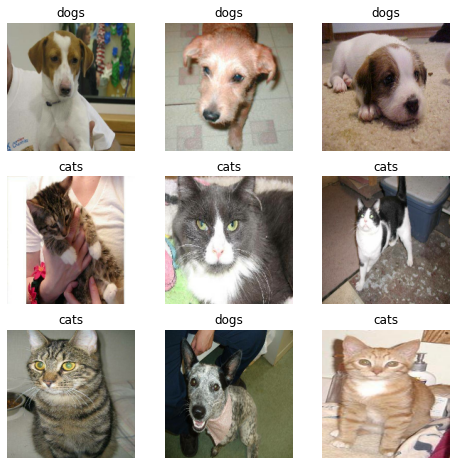

In [6]:
plt.figure(figsize=(8, 8))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Аналогчним чином створимо тестовий набір даних. Вкажемо лише адресу папки з тестовими зображеннями (як і для навчальних даних, зображення кожного класу повинні розміщуватись в окремій папці), а також розмір батчу та зображення.

In [7]:
test_dataset = image_dataset_from_directory('D:/Drive/ІІС/Datasets/Conv_2cl/cat_dog/test_set',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.


Перевіримо, чи правильно зчитались імена класів.

In [8]:
test_dataset.class_names

['cats', 'dogs']

Все добре. Далі необхідно написати службовий код, який оптимізує процедуру роботи з відеокартою.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Створюємо модель згорткової нейронної мережі. Оберемо наступну архітектуру:

1. Службовий прошарок для стандартизації значень в пікселях зображення (переведення з діапазону 0-255 до діапазону 0-1).
2. Вхідний згортковий прошарок (кількість фільтрів - 32, розмір фільтру - 5х5, padding - однаковий з усіх країв, розмірність вхідного зображення - 180х180х3 [палітра RGB має три кольорових канали], активаційна функція - ReLU).
3. Прошарок підвибірки (розмір фільтру - 2х2).
4. Прошарок дропауту для регуляризації (випадково вимикаємо 20% нейронів попереднього прошарку)
5. Другий згортковий прошарок (кількість фільтрів - 64, розмір фільтру - 3х3, padding - однаковий, активаційна функція - ReLU).
6. Прошарок підвибірки (розмір фільтру - 2х2).
7. Прошарок дропауту.
8. Третій згортковий прошарок (кількість фільтрів - 128, розмір фільтру - 3х3, padding - однаковий, активаційна функція - ReLU).
9. Прошарок підвибірки (розмір фільтру - 2х2).
10. Прошарок дропауту.
11. Четвертий згортковий прошарок (кількість фільтрів - 256, розмір фільтру - 3х3, padding - однаковий, активаційна функція - ReLU).
12. Прошарок підвибірки (розмір фільтру - 2х2).
13. Прошарок дропауту.
14. Службовий прошарок для перетворення набору ознак у одновимірний вектор.
15. Повнозв'язний прошарок для класифікації (512 нейронів, активаційна функція - ReLU, регуляризація ваг - L2).
16. Прошарок дропауту.
17. Вихідний прошарок з одним нейроном, значення якого може бути 0 (коти) або 1 (собаки) (активаційна функція - сигмоїдальна).

In [10]:
# Створюємо послідовну модель
model = Sequential()

# Додаємо прошарок стандартизації значень пікселів
model.add(Rescaling(scale=1./255))

# Згортковий прошарок
model.add(Conv2D(32, (5, 5), padding='same', 
                 input_shape=(180, 180, 3), activation='relu'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Згортковий прошарок
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# Прошарок підвибірки
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


# Повнозв'язна частина нейронної мережі для класифікації
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.2))

# Вихідний прошарок, 1 нейрон
model.add(Dense(1, activation='sigmoid'))

Компілюємо модель. Критерій якості - бінарна крос-ентропія (оскільки в задачі рівно 2 класи), оптимізатор - Adam (для конкретно цієї задачі - зі зменшеною швидкістю навчання; в інших випадках, скоріш за все, підійдуть стандартні значення), метрика - Accuracy.

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

Переглянемо зведену інформацію щодо архітектури моделі. Як бачимо, задана мережа має 16 250 689 внутрішніх параметрів.

In [12]:
model.build((1, 180, 180,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (1, 180, 180, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (1, 180, 180, 32)         2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 90, 90, 32)           0         
_________________________________________________________________
dropout (Dropout)            (1, 90, 90, 32)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 90, 90, 64)           18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 45, 45, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (1, 45, 45, 64)           0

Начаємо нейронну мережу. Вказуємо навчальний набір даних, набір даних для валідації та кількість епох.

In [13]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=25)

Epoch 1/25
107/107 [==============================] - 19s 179ms/step - loss: 5.4208 - accuracy: 0.5129 - val_loss: 2.1950 - val_accuracy: 0.5167
Epoch 2/25
107/107 [==============================] - 19s 173ms/step - loss: 1.3841 - accuracy: 0.5591 - val_loss: 0.9564 - val_accuracy: 0.5742
Epoch 3/25
107/107 [==============================] - 19s 173ms/step - loss: 0.8205 - accuracy: 0.6162 - val_loss: 0.7336 - val_accuracy: 0.6875
Epoch 4/25
107/107 [==============================] - 19s 173ms/step - loss: 0.6817 - accuracy: 0.6675 - val_loss: 0.6394 - val_accuracy: 0.7275
Epoch 5/25
107/107 [==============================] - 19s 173ms/step - loss: 0.6303 - accuracy: 0.6912 - val_loss: 0.6297 - val_accuracy: 0.6742
Epoch 6/25
107/107 [==============================] - 19s 173ms/step - loss: 0.6116 - accuracy: 0.7050 - val_loss: 0.5942 - val_accuracy: 0.7192
Epoch 7/25
107/107 [==============================] - 19s 174ms/step - loss: 0.5945 - accuracy: 0.7090 - val_loss: 0.5823 - val_ac

Побудуємо графіки навчання.

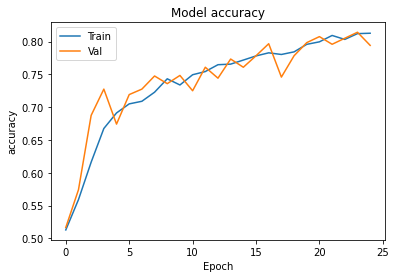

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Перенавчання немає.

Виконаємо оцінку якості роботи мережі на тестових даних.

In [16]:
scores = model.evaluate(test_dataset)

32/32 [==============================] - 2s 67ms/step - loss: 0.5102 - accuracy: 0.7835


In [17]:
print("Доля вірних відповідей на тестових даних, у відсотках:", round(scores[1] * 100, 4))

Доля вірних відповідей на тестових даних, у відсотках: 78.35


Застосуємо створену модель для класифікації довільного зображення. Імпортуємо функції для завантаження зображення в програму.

In [18]:
from IPython.display import Image
from tkinter.filedialog import askopenfilename

Виконаємо попередню обробку (масштабування та перетворення зображення в масив Numpy) та подамо його на вхід мережі для отримання відповіді.

(-0.5, 179.5, 179.5, -0.5)

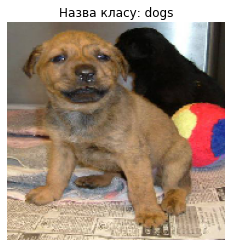

In [19]:
# Викликаємо віконце для вибору файлу
img_path = askopenfilename()
# Імпортуємо зображення та масштабуємо його (img_path, ширина=180, висота=180)
img = image.load_img(img_path, target_size=(180, 180))

# Перетворюємо зображення в масив
x = image.img_to_array(img)
x = x.reshape(-1,180, 180, 3)

# Подаємо зображення на вхід мережі для класифікації
prediction = model.predict(x)

# Визначаємо код класу
prediction = int(np.round(prediction))

# Показуємо результат
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Назва класу: {class_names[prediction]}" )
plt.axis("off")